In [2]:
%matplotlib inline

import matplotlib
# matplotlib.use('pgf')
# pgf_with_rc_fonts = {
#     "font.family": "serif",
#     "font.serif": [],                   # use latex default serif font
#     "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
#     "pgf.rcfonts" : False
# }
# matplotlib.rcParams.update(pgf_with_rc_fonts)

from matplotlib import rc
import matplotlib.pyplot as plt

import scipy.stats as st
import numpy as np
import json

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts")

import helper as h
from CameraModel import Camera
from RoadModel import Road, NormalProbabilityDist
from Path import Path

plt.style.use('ggplot')
from matplotlib import rc

rc('text', usetex=True)
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = '0.4'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['grid.color'] = "0.9"

plt.tight_layout(.5)


# Single Camera

All analysis here is conducted with a simpler objective function: maximizing ( expected improvement in location uncertainty).
    
This directly related to the kalman gain: as measurement noise -> 0, kalmain gain -> 1 and the measurement is taken as more as better truth estimator. If measurement noise is very large, kalman gain -> 0 and measurement is ignored. We obtain the best reduction in KF covariance by therefore maximizing the kalman gain, or minimizing measurement noise.
    
Therefore, the goal of maximizing expected localization uncertainty improvement is equivalent to minimizing expected measurement noise R_k. Across the pixel plane therefore, we can use the sum(prob of vehicle center being in pixel * measurement error at that pixel)

In [3]:
# will use the same probability distribution across all experiments
road_prob_dist = NormalProbabilityDist(two_stddev=0.4) # vehicles will 95% of time be +-0.4 meter of center of road
#
resolution = (300,300)

In [4]:
def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=4.0, # note: changed
                               verbose=False,
                               orientation_percent=0.9,
                               pos_percent=0.9,
                               alg_percent=0.9,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    # TODO this is wrong implementation! Doesn't matter though really as long as use is consistent
    # but really it should be -1*norm.ppf((1-percent)/2.0)
    # as it is is an underestimate

    stddevs_orientation = st.norm.ppf(orientation_percent)
    stddevs_position = st.norm.ppf(pos_percent)
    stddevs_alg = st.norm.ppf(alg_percent)
    
    
    # NOT invariant between pixels
    z_error = (ground_distance/camera_height)*stddevs_position*sigma_pos if use_err_z else 0
    
    # NOT invariant between pixels
    if use_err_orient:
        t = stddevs_orientation*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        beta = alpha + t
        if beta > np.pi/2: # causes tan to roll over into negatives...
            orientation_error = 9999999999
        else:
            orientation_error = np.tan(beta)*camera_height - ground_distance
    else:
        orientation_error = 0
    
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
#     print("Z error: {0}".format(z_error))
#     print("orien error: {0}".format(orientation_error))
#     print("pixel_error: {0}".format(pixel_error))
    total = z_error + orientation_error + (alg_error+1)/2.0 * stddevs_alg * pixel_error
    return total, z_error, orientation_error, alg_error*pixel_error

In [5]:
def error_radius_across_pixels(camera):
    
    image = np.zeros(shape=(camera.R_y, camera.R_x+1)) # add one because using pixel as bottom left corner! Symmetry matters here
    camera_x, camera_y, camera_z = camera.position
    camera_ground_pos = np.array([camera_x, camera_y, 0.0])

    for (y,x), _ in np.ndenumerate(image):

        ground_point = camera.pixel_to_plane(x, y)
        pixel_area = camera.plane_area_of_pixel(x,y)

        if ground_point is None or pixel_area is None:
            image[y, x] = 999999999999
            continue

        ground_distance = np.linalg.norm(ground_point - camera_ground_pos)

        image[y, x] = get_predicted_error_radius(camera_z, ground_distance, pixel_area)[0]

        return image
        

## Straight Road

Constant FOV of 60 deg, and fix resolution at 300x300

In [24]:
camera_height = 6.0
resolution = (300, 300)
fov_deg = (60.0, 60.0)
yaw_range = 90 # degrees +- from center yaw position

curvature = 0.0
length = 40.0 # needs to be long enough to exceed camera view at 0 and 180 deg yaw!

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitches = np.arange(31.0, 92.0, 3)

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)


In [5]:

scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
for j, yaw in enumerate(camera_yaws):
    for i, pitch in enumerate(camera_pitches):
        print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
        name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
        camera = Camera(camera_position, pitch, yaw)
        camera.set_resolution(*resolution)
        camera.set_fov(*fov_deg)

        pixel_probabilities = camera.get_pixel_probabilities_for_road(road)
        
        # didn't want any pyplot stuff running
        # in case of leaking memory from open figures that I don't quite understand
        
#         plt.imshow(pixel_probabilities)
#         plt.gray()
#         plt.imsave(save_dir + name + "_road_probabilities.png")
#         plt.cla()
#         plt.clf()
        
        
        # calculate error radius at each pixel
        error_bounds = error_radius_across_pixels(camera)
#         plt.imshow(error_bounds)
#         plt.gray()
#         plt.imsave(save_dir + name + "_error_bounds.png")
        
        target = (1.0/(1+error_bounds)) * pixel_probabilities
#         plt.imshow(product)
#         plt.gray()
#         plt.imsave(save_dir + name + "_product.png")
        # take the sum => now have an expected value!
        
        score = np.sum(target)
        print("Score: {0}".format(score))
        scores[i, j] = score

Processing: pitch -- 31.0, yaw -- 0.0
Score: 12.2264695874
Processing: pitch -- 34.0, yaw -- 0.0
Score: 13.3390263898
Processing: pitch -- 37.0, yaw -- 0.0
Score: 14.5126584944
Processing: pitch -- 40.0, yaw -- 0.0
Score: 15.6589314216
Processing: pitch -- 43.0, yaw -- 0.0
Score: 16.8568764827
Processing: pitch -- 46.0, yaw -- 0.0
Score: 18.0623267958
Processing: pitch -- 49.0, yaw -- 0.0
Score: 18.8878090159
Processing: pitch -- 52.0, yaw -- 0.0
Score: 19.5383028098
Processing: pitch -- 55.0, yaw -- 0.0
Score: 20.1422142281
Processing: pitch -- 58.0, yaw -- 0.0
Score: 20.7154862428
Processing: pitch -- 61.0, yaw -- 0.0
Score: 21.2726497643
Processing: pitch -- 64.0, yaw -- 0.0
Score: 21.8260084125
Processing: pitch -- 67.0, yaw -- 0.0
Score: 22.3845598596
Processing: pitch -- 70.0, yaw -- 0.0
Score: 22.9522513378
Processing: pitch -- 73.0, yaw -- 0.0
Score: 23.5254365009
Processing: pitch -- 76.0, yaw -- 0.0
Score: 24.0899785128
Processing: pitch -- 79.0, yaw -- 0.0
Score: 24.61943842

Score: 22.609383899
Processing: pitch -- 67.0, yaw -- 60.0
Score: 22.8356769721
Processing: pitch -- 70.0, yaw -- 60.0
Score: 23.1933104421
Processing: pitch -- 73.0, yaw -- 60.0
Score: 23.6758749569
Processing: pitch -- 76.0, yaw -- 60.0
Score: 23.6462130866
Processing: pitch -- 79.0, yaw -- 60.0
Score: 22.2476173336
Processing: pitch -- 82.0, yaw -- 60.0
Score: 20.4773775061
Processing: pitch -- 85.0, yaw -- 60.0
Score: 18.5442747724
Processing: pitch -- 88.0, yaw -- 60.0
Score: 16.4286633867
Processing: pitch -- 91.0, yaw -- 60.0
Score: 14.1034081211
Processing: pitch -- 31.0, yaw -- 70.0
Score: 11.8280554943
Processing: pitch -- 34.0, yaw -- 70.0
Score: 15.7326697505
Processing: pitch -- 37.0, yaw -- 70.0
Score: 19.5028125333
Processing: pitch -- 40.0, yaw -- 70.0
Score: 22.8215805054
Processing: pitch -- 43.0, yaw -- 70.0
Score: 23.911703302
Processing: pitch -- 46.0, yaw -- 70.0
Score: 23.3326023118
Processing: pitch -- 49.0, yaw -- 70.0
Score: 22.7080068163
Processing: pitch -- 

Score: 14.7944164143
Processing: pitch -- 34.0, yaw -- 130.0
Score: 16.5072191739
Processing: pitch -- 37.0, yaw -- 130.0
Score: 18.235198535
Processing: pitch -- 40.0, yaw -- 130.0
Score: 19.9829545343
Processing: pitch -- 43.0, yaw -- 130.0
Score: 21.7454211708
Processing: pitch -- 46.0, yaw -- 130.0
Score: 23.3185162597
Processing: pitch -- 49.0, yaw -- 130.0
Score: 24.0252106653
Processing: pitch -- 52.0, yaw -- 130.0
Score: 23.9627458782
Processing: pitch -- 55.0, yaw -- 130.0
Score: 23.8235662742
Processing: pitch -- 58.0, yaw -- 130.0
Score: 23.8031957724
Processing: pitch -- 61.0, yaw -- 130.0
Score: 23.9138655509
Processing: pitch -- 64.0, yaw -- 130.0
Score: 24.1487607103
Processing: pitch -- 67.0, yaw -- 130.0
Score: 24.050874886
Processing: pitch -- 70.0, yaw -- 130.0
Score: 23.155220776
Processing: pitch -- 73.0, yaw -- 130.0
Score: 22.09483134
Processing: pitch -- 76.0, yaw -- 130.0
Score: 20.9563364288
Processing: pitch -- 79.0, yaw -- 130.0
Score: 19.7293059724
Processi

In [6]:
# save above to file to not lose it! very expensive computation
np.save("straight_road_40m_{0}x{1}0_6m_pitch_yaw_scores_0-4_two_stddev.npy".format(*resolution), scores)

In [20]:
# recover data
scores = np.load("straight_road_40m_{0}x{1}0_6m_pitch_yaw_scores_0-4_two_stddev.npy".format(*resolution))

[ 20.  -3.   6.]


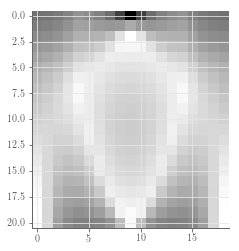

In [27]:
print(camera_position)
plt.imshow(scores)
plt.gray()
plt.show()

In [22]:
# get sorted indices
sorted_indices = np.array(np.unravel_index(np.argsort(scores, axis=None), scores.shape)).T
print(sorted_indices)


[[ 0  9]
 [ 0 10]
 [ 0  8]
 [ 0 11]
 [ 0  7]
 [ 0  0]
 [ 0 18]
 [ 0  1]
 [ 0 17]
 [ 0  2]
 [ 0 16]
 [ 1  0]
 [ 1 18]
 [ 1  1]
 [ 1 17]
 [20  5]
 [20 13]
 [ 0 12]
 [ 0  6]
 [20 14]
 [20  4]
 [ 0  3]
 [ 0 15]
 [20  6]
 [20 12]
 [ 1  2]
 [ 1 16]
 [ 2  0]
 [ 2 18]
 [20 15]
 [20  3]
 [ 0  5]
 [ 0 13]
 [ 2  1]
 [ 2 17]
 [19 14]
 [19  4]
 [ 1  3]
 [ 1 15]
 [19  5]
 [19 13]
 [ 0  4]
 [ 0 14]
 [20  7]
 [20 11]
 [ 2  2]
 [ 2 16]
 [ 3  0]
 [ 3 18]
 [19 15]
 [19  3]
 [ 1  7]
 [ 1 11]
 [ 1  8]
 [ 1 10]
 [ 1  6]
 [ 1 12]
 [ 3  1]
 [ 3 17]
 [18 14]
 [18  4]
 [19  6]
 [19 12]
 [ 1  5]
 [ 1 13]
 [20  2]
 [20 16]
 [ 2  3]
 [ 2 15]
 [18  3]
 [18 15]
 [ 1  4]
 [ 1 14]
 [ 3  2]
 [ 4  0]
 [ 3 16]
 [ 4 18]
 [18  5]
 [18 13]
 [19  2]
 [19 16]
 [ 4  1]
 [ 4 17]
 [17 14]
 [17  4]
 [ 1  9]
 [17  3]
 [17 15]
 [ 5  0]
 [18  2]
 [18 16]
 [ 5 18]
 [ 3  3]
 [ 3 15]
 [ 4  2]
 [ 2  5]
 [ 2 13]
 [ 4 16]
 [ 2  4]
 [ 2 14]
 [17 13]
 [17  5]
 [ 2  6]
 [ 2 12]
 [16  3]
 [16 15]
 [18  6]
 [18 12]
 [16 14]
 [16  4]
 [17  2]
 

Pitches: 
[ 31.  34.  37.  40.  43.  46.  49.  52.  55.  58.  61.  64.  67.  70.  73.
  76.  79.  82.  85.  88.  91.]
Yaws: 
[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.]
Score: 24.6194 -- Pitch: 79.0, Yaw: 0.0 (index 16, 0)


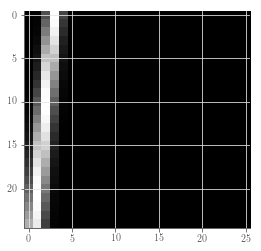

Score: 24.6198 -- Pitch: 79.0, Yaw: 180.0 (index 16, 18)


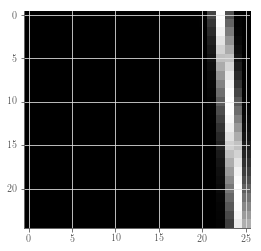

Score: 24.6650 -- Pitch: 40.0, Yaw: 80.0 (index 3, 8)


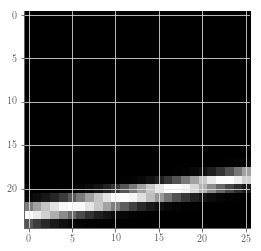

Score: 24.6652 -- Pitch: 40.0, Yaw: 100.0 (index 3, 10)


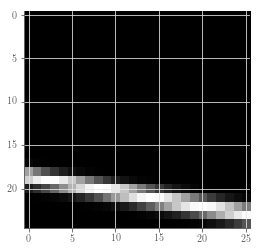

Score: 24.7185 -- Pitch: 40.0, Yaw: 90.0 (index 3, 9)


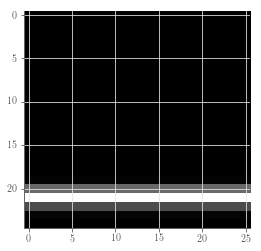

Score: 24.9085 -- Pitch: 91.0, Yaw: 90.0 (index 20, 9)


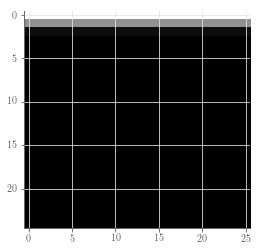

Score: 24.9417 -- Pitch: 55.0, Yaw: 40.0 (index 8, 4)


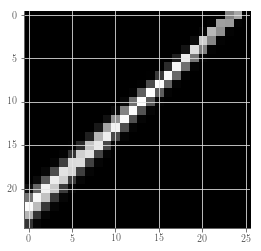

Score: 24.9418 -- Pitch: 55.0, Yaw: 140.0 (index 8, 14)


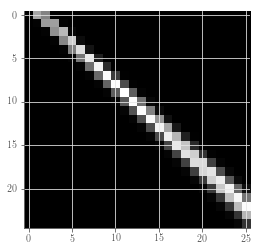

Score: 24.9694 -- Pitch: 52.0, Yaw: 40.0 (index 7, 4)


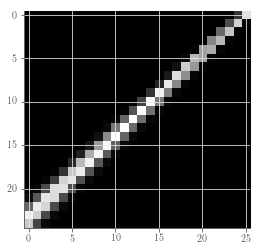

Score: 24.9698 -- Pitch: 52.0, Yaw: 140.0 (index 7, 14)


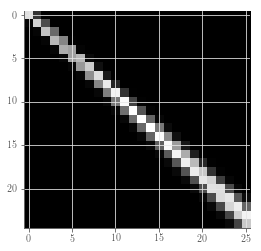

Score: 25.0768 -- Pitch: 82.0, Yaw: 0.0 (index 17, 0)


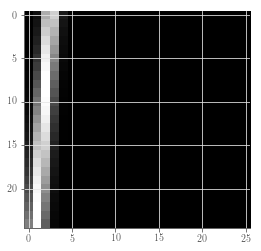

Score: 25.0770 -- Pitch: 82.0, Yaw: 180.0 (index 17, 18)


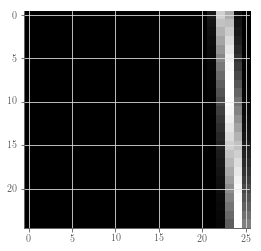

Score: 25.1078 -- Pitch: 88.0, Yaw: 90.0 (index 19, 9)


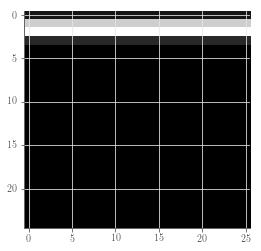

Score: 25.4210 -- Pitch: 85.0, Yaw: 0.0 (index 18, 0)


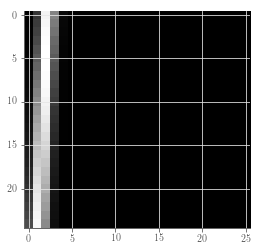

Score: 25.4212 -- Pitch: 85.0, Yaw: 180.0 (index 18, 18)


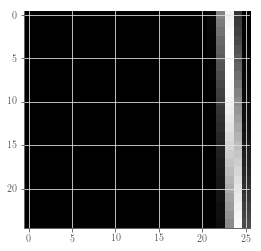

Score: 25.6173 -- Pitch: 88.0, Yaw: 0.0 (index 19, 0)


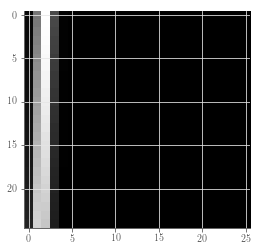

Score: 25.6174 -- Pitch: 88.0, Yaw: 180.0 (index 19, 18)


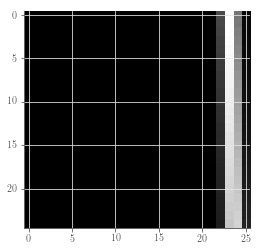

Score: 25.6448 -- Pitch: 91.0, Yaw: 0.0 (index 20, 0)


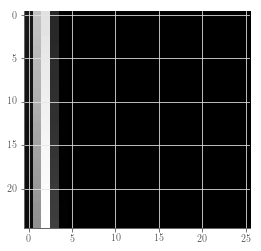

Score: 25.6448 -- Pitch: 91.0, Yaw: 180.0 (index 20, 18)


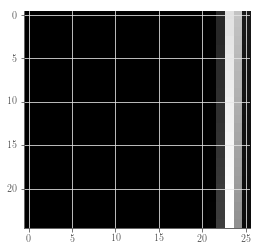

Score: 25.6555 -- Pitch: 37.0, Yaw: 90.0 (index 2, 9)


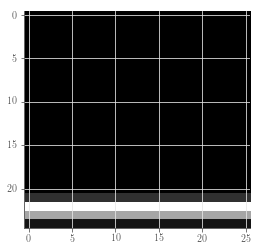

In [26]:
# look at the top 10 scores


print("Pitches: \n{0}".format(camera_pitches))
print("Yaws: \n{0}".format(camera_yaws))
for pitch_index, yaw_index in sorted_indices[-20:]:
    pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
    print("Score: {2:.4f} -- Pitch: {0}, Yaw: {1} (index {3}, {4})".format(pitch, yaw, scores[pitch_index, yaw_index], pitch_index, yaw_index))
    
    c = Camera(camera_position, pitch, yaw)
    c.set_resolution(25, 25)
    c.set_fov(*fov_deg)
    
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()


In [10]:
"""
pitch_index, yaw_index= 2, 9
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(25, 25)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
error_bounds = error_radius_across_pixels(c)
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()
"""

'\npitch_index, yaw_index= 2, 9\npitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]\nprint("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))\nc = Camera(camera_position, pitch, yaw)\nc.set_resolution(25, 25)\nc.set_fov(*fov_deg)\npixel_probabilities = c.get_pixel_probabilities_for_road(road)\nerror_bounds = error_radius_across_pixels(c)\ntarget = (1.0/(1+error_bounds)) * pixel_probabilities\nscore = np.sum(target)\nprint("Score: {0}".format(score))\nplt.imshow(np.flip(pixel_probabilities, 0))\nplt.gray()\nplt.show()\n'

In [11]:
"""
pitch_index, yaw_index = 7, 14
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(100, 100)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
print("Sum pixel probabilities: {0}".format(np.sum(pixel_probabilities)))
error_bounds = error_radius_across_pixels(c)
print("Sum error bounds: {0}".format(np.sum(error_bounds)))
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()
"""

'\npitch_index, yaw_index = 7, 14\npitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]\nprint("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))\nc = Camera(camera_position, pitch, yaw)\nc.set_resolution(100, 100)\nc.set_fov(*fov_deg)\npixel_probabilities = c.get_pixel_probabilities_for_road(road)\nprint("Sum pixel probabilities: {0}".format(np.sum(pixel_probabilities)))\nerror_bounds = error_radius_across_pixels(c)\nprint("Sum error bounds: {0}".format(np.sum(error_bounds)))\ntarget = (1.0/(1+error_bounds)) * pixel_probabilities\nscore = np.sum(target)\nprint("Score: {0}".format(score))\nplt.imshow(np.flip(pixel_probabilities, 0))\nplt.gray()\nplt.show()\n'

In [12]:
"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scores_flat = scores.ravel()
ps, ys = np.meshgrid(camera_pitches, camera_yaws)
ps_, ys_ = ps.ravel(), ys.ravel()
bottom = np.zeros_like(ps_)
width = ps[0, 1] - ps[0,0]
depth = ys[0,0] - ys[1,0]
print(ps_.shape, ys_.shape, scores.ravel().shape)
print(width, depth)
ax.bar3d(ps_, ys_, bottom, width, depth, scores.ravel(), shade=True)
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nscores_flat = scores.ravel()\nps, ys = np.meshgrid(camera_pitches, camera_yaws)\nps_, ys_ = ps.ravel(), ys.ravel()\nbottom = np.zeros_like(ps_)\nwidth = ps[0, 1] - ps[0,0]\ndepth = ys[0,0] - ys[1,0]\nprint(ps_.shape, ys_.shape, scores.ravel().shape)\nprint(width, depth)\nax.bar3d(ps_, ys_, bottom, width, depth, scores.ravel(), shade=True)\nplt.show()\n"

In [13]:
"""
c2 = Camera(camera_position, 55, 25)
c2.set_resolution(200,200)
pixel_probabilities = c2.get_pixel_probabilities_for_road(road)
pitch = 55
for y in camera_yaws:
    print(y)
    c = Camera(camera_position, pitch, y)
    c.set_resolution(50, 50)
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    # flip the y axis for displaying as an image...
    
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()
"""

'\nc2 = Camera(camera_position, 55, 25)\nc2.set_resolution(200,200)\npixel_probabilities = c2.get_pixel_probabilities_for_road(road)\npitch = 55\nfor y in camera_yaws:\n    print(y)\n    c = Camera(camera_position, pitch, y)\n    c.set_resolution(50, 50)\n    pixel_probabilities = c.get_pixel_probabilities_for_road(road)\n    # flip the y axis for displaying as an image...\n    \n    plt.imshow(np.flip(pixel_probabilities, 0))\n    plt.gray()\n    plt.show()\n'

## Take into account Curvature
how to handle edge of roads? usually have an occlusion... 
* add a cylinder at the position the camera is located! => raytracer will intersect this

In [29]:
def plot_vector(axis, vec_start, vec_end):
    x,y,z =vec_start
    u,v,w = vec_end - vec_start
    axis.quiver(x,y,z,u,v,w)
def plot_points(axis, points):
    if points.shape[0] == 0:
        return
    axis.scatter(points[:, 0], points[:, 1], points[:, 2])

In [30]:
curvatures = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
# curvatures = [0.1]
curvature_score_maps = []
# separate cell => abort and can save partial results

---- Curvature: 0.001 ----
Cylinder radius: 997.0
Road radius: 1000.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 13.3516685383
Processing: pitch -- 34.0, yaw -- 180.0
Score: 14.4826218867
Processing: pitch -- 37.0, yaw -- 180.0
Score: 15.5331570662
Processing: pitch -- 40.0, yaw -- 180.0
Score: 16.5007316145
Processing: pitch -- 43.0, yaw -- 180.0
Score: 17.3784592948
Processing: pitch -- 46.0, yaw -- 180.0
Score: 18.1690269357
Processing: pitch -- 49.0, yaw -- 180.0
Score: 18.882696525
Processing: pitch -- 52.0, yaw -- 180.0
Score: 19.5340353542
Processing: pitch -- 55.0, yaw -- 180.0
Score: 20.1390644864
Processing: pitch -- 58.0, yaw -- 180.0
Score: 20.7134535898
Processing: pitch -- 61.0, yaw -- 180.0
Score: 21.2714784913
Processing: pitch -- 64.0, yaw -- 180.0
Score: 21.8252185015
Processing: pitch -- 67.0, yaw -- 180.0
Score: 22.3835072691
Processing: pitch -- 70.0, yaw -- 180.0
Score: 22.9502230645
Processing: pitch -- 73.0, yaw -- 180.0
Score: 23.521821063
Processing: pitch

Score: 22.9745288881
Processing: pitch -- 55.0, yaw -- 240.0
Score: 22.6983729513
Processing: pitch -- 58.0, yaw -- 240.0
Score: 22.5501649011
Processing: pitch -- 61.0, yaw -- 240.0
Score: 22.5266181472
Processing: pitch -- 64.0, yaw -- 240.0
Score: 22.6272218393
Processing: pitch -- 67.0, yaw -- 240.0
Score: 22.8542134256
Processing: pitch -- 70.0, yaw -- 240.0
Score: 23.2126697269
Processing: pitch -- 73.0, yaw -- 240.0
Score: 23.6912036045
Processing: pitch -- 76.0, yaw -- 240.0
Score: 23.5954594443
Processing: pitch -- 79.0, yaw -- 240.0
Score: 22.1811144822
Processing: pitch -- 82.0, yaw -- 240.0
Score: 20.428324114
Processing: pitch -- 85.0, yaw -- 240.0
Score: 18.5104812999
Processing: pitch -- 88.0, yaw -- 240.0
Score: 16.4070122552
Processing: pitch -- 91.0, yaw -- 240.0
Score: 14.0905368057
Processing: pitch -- 31.0, yaw -- 250.0
Score: 11.8504997995
Processing: pitch -- 34.0, yaw -- 250.0
Score: 15.7435370122
Processing: pitch -- 37.0, yaw -- 250.0
Score: 19.5170244602
Proc

Score: 22.1811144822
Processing: pitch -- 82.0, yaw -- 300.0
Score: 20.428324114
Processing: pitch -- 85.0, yaw -- 300.0
Score: 18.5104812999
Processing: pitch -- 88.0, yaw -- 300.0
Score: 16.4070122552
Processing: pitch -- 91.0, yaw -- 300.0
Score: 14.0905368057
Processing: pitch -- 31.0, yaw -- 310.0
Score: 14.8332119931
Processing: pitch -- 34.0, yaw -- 310.0
Score: 16.5423598506
Processing: pitch -- 37.0, yaw -- 310.0
Score: 18.2687882659
Processing: pitch -- 40.0, yaw -- 310.0
Score: 20.0169208091
Processing: pitch -- 43.0, yaw -- 310.0
Score: 21.7814415256
Processing: pitch -- 46.0, yaw -- 310.0
Score: 23.3561828922
Processing: pitch -- 49.0, yaw -- 310.0
Score: 24.0607964159
Processing: pitch -- 52.0, yaw -- 310.0
Score: 23.9970912387
Processing: pitch -- 55.0, yaw -- 310.0
Score: 23.8586355161
Processing: pitch -- 58.0, yaw -- 310.0
Score: 23.8394258547
Processing: pitch -- 61.0, yaw -- 310.0
Score: 23.9514683561
Processing: pitch -- 64.0, yaw -- 310.0
Score: 24.1807648414
Proc

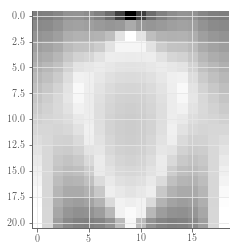

---- Curvature: 0.005 ----
Cylinder radius: 197.0
Road radius: 200.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 13.3049211229
Processing: pitch -- 34.0, yaw -- 180.0
Score: 14.4968277131
Processing: pitch -- 37.0, yaw -- 180.0
Score: 15.5406805118
Processing: pitch -- 40.0, yaw -- 180.0
Score: 16.4981305861
Processing: pitch -- 43.0, yaw -- 180.0
Score: 17.3689614101
Processing: pitch -- 46.0, yaw -- 180.0
Score: 18.1562121439
Processing: pitch -- 49.0, yaw -- 180.0
Score: 18.8698134981
Processing: pitch -- 52.0, yaw -- 180.0
Score: 19.5234454134
Processing: pitch -- 55.0, yaw -- 180.0
Score: 20.1320144212
Processing: pitch -- 58.0, yaw -- 180.0
Score: 20.7100616264
Processing: pitch -- 61.0, yaw -- 180.0
Score: 21.2708168009
Processing: pitch -- 64.0, yaw -- 180.0
Score: 21.8254591713
Processing: pitch -- 67.0, yaw -- 180.0
Score: 22.382148317
Processing: pitch -- 70.0, yaw -- 180.0
Score: 22.9444751101
Processing: pitch -- 73.0, yaw -- 180.0
Score: 23.5092599914
Processing: pitch

Score: 23.0437076094
Processing: pitch -- 55.0, yaw -- 240.0
Score: 22.7687841512
Processing: pitch -- 58.0, yaw -- 240.0
Score: 22.6221296068
Processing: pitch -- 61.0, yaw -- 240.0
Score: 22.6004972222
Processing: pitch -- 64.0, yaw -- 240.0
Score: 22.7034155842
Processing: pitch -- 67.0, yaw -- 240.0
Score: 22.9331742281
Processing: pitch -- 70.0, yaw -- 240.0
Score: 23.2948763841
Processing: pitch -- 73.0, yaw -- 240.0
Score: 23.7401473742
Processing: pitch -- 76.0, yaw -- 240.0
Score: 23.3678994107
Processing: pitch -- 79.0, yaw -- 240.0
Score: 21.9256611786
Processing: pitch -- 82.0, yaw -- 240.0
Score: 20.2391085756
Processing: pitch -- 85.0, yaw -- 240.0
Score: 18.3790293851
Processing: pitch -- 88.0, yaw -- 240.0
Score: 16.3221537498
Processing: pitch -- 91.0, yaw -- 240.0
Score: 14.0397934185
Processing: pitch -- 31.0, yaw -- 250.0
Score: 11.9412682269
Processing: pitch -- 34.0, yaw -- 250.0
Score: 15.7892476707
Processing: pitch -- 37.0, yaw -- 250.0
Score: 19.5765469488
Pro

Score: 21.9256611786
Processing: pitch -- 82.0, yaw -- 300.0
Score: 20.2391085756
Processing: pitch -- 85.0, yaw -- 300.0
Score: 18.3790293851
Processing: pitch -- 88.0, yaw -- 300.0
Score: 16.3221537498
Processing: pitch -- 91.0, yaw -- 300.0
Score: 14.0397934185
Processing: pitch -- 31.0, yaw -- 310.0
Score: 15.005752255
Processing: pitch -- 34.0, yaw -- 310.0
Score: 16.6999005082
Processing: pitch -- 37.0, yaw -- 310.0
Score: 18.4195914085
Processing: pitch -- 40.0, yaw -- 310.0
Score: 20.1686724421
Processing: pitch -- 43.0, yaw -- 310.0
Score: 21.9408976224
Processing: pitch -- 46.0, yaw -- 310.0
Score: 23.521676963
Processing: pitch -- 49.0, yaw -- 310.0
Score: 24.2174428969
Processing: pitch -- 52.0, yaw -- 310.0
Score: 24.148524693
Processing: pitch -- 55.0, yaw -- 310.0
Score: 24.0126757719
Processing: pitch -- 58.0, yaw -- 310.0
Score: 23.9978229231
Processing: pitch -- 61.0, yaw -- 310.0
Score: 24.1149021915
Processing: pitch -- 64.0, yaw -- 310.0
Score: 24.2630487504
Proces

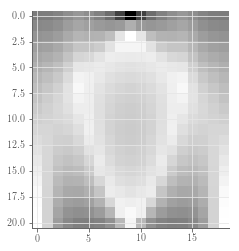

---- Curvature: 0.01 ----
Cylinder radius: 97.0
Road radius: 100.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 13.2688739992
Processing: pitch -- 34.0, yaw -- 180.0
Score: 14.4517690756
Processing: pitch -- 37.0, yaw -- 180.0
Score: 15.5907836874
Processing: pitch -- 40.0, yaw -- 180.0
Score: 16.5252719559
Processing: pitch -- 43.0, yaw -- 180.0
Score: 17.3815131174
Processing: pitch -- 46.0, yaw -- 180.0
Score: 18.1605320381
Processing: pitch -- 49.0, yaw -- 180.0
Score: 18.8709525717
Processing: pitch -- 52.0, yaw -- 180.0
Score: 19.5249234375
Processing: pitch -- 55.0, yaw -- 180.0
Score: 20.1357789602
Processing: pitch -- 58.0, yaw -- 180.0
Score: 20.7165423656
Processing: pitch -- 61.0, yaw -- 180.0
Score: 21.2790865667
Processing: pitch -- 64.0, yaw -- 180.0
Score: 21.8334357654
Processing: pitch -- 67.0, yaw -- 180.0
Score: 22.3868810749
Processing: pitch -- 70.0, yaw -- 180.0
Score: 22.9426174676
Processing: pitch -- 73.0, yaw -- 180.0
Score: 23.4978385781
Processing: pitch 

Score: 23.143032575
Processing: pitch -- 55.0, yaw -- 240.0
Score: 22.8693919356
Processing: pitch -- 58.0, yaw -- 240.0
Score: 22.7244514446
Processing: pitch -- 61.0, yaw -- 240.0
Score: 22.7050111401
Processing: pitch -- 64.0, yaw -- 240.0
Score: 22.8106590066
Processing: pitch -- 67.0, yaw -- 240.0
Score: 23.043750639
Processing: pitch -- 70.0, yaw -- 240.0
Score: 23.408787091
Processing: pitch -- 73.0, yaw -- 240.0
Score: 23.7484379992
Processing: pitch -- 76.0, yaw -- 240.0
Score: 23.0508646142
Processing: pitch -- 79.0, yaw -- 240.0
Score: 21.6289764675
Processing: pitch -- 82.0, yaw -- 240.0
Score: 20.0169864229
Processing: pitch -- 85.0, yaw -- 240.0
Score: 18.2225253825
Processing: pitch -- 88.0, yaw -- 240.0
Score: 16.219818135
Processing: pitch -- 91.0, yaw -- 240.0
Score: 13.9779810943
Processing: pitch -- 31.0, yaw -- 250.0
Score: 12.0575547055
Processing: pitch -- 34.0, yaw -- 250.0
Score: 15.8518310814
Processing: pitch -- 37.0, yaw -- 250.0
Score: 19.6573705147
Process

Score: 21.6289764675
Processing: pitch -- 82.0, yaw -- 300.0
Score: 20.0169864229
Processing: pitch -- 85.0, yaw -- 300.0
Score: 18.2225253825
Processing: pitch -- 88.0, yaw -- 300.0
Score: 16.219818135
Processing: pitch -- 91.0, yaw -- 300.0
Score: 13.9779810943
Processing: pitch -- 31.0, yaw -- 310.0
Score: 15.2775391549
Processing: pitch -- 34.0, yaw -- 310.0
Score: 16.9506266249
Processing: pitch -- 37.0, yaw -- 310.0
Score: 18.6592870248
Processing: pitch -- 40.0, yaw -- 310.0
Score: 20.4069412358
Processing: pitch -- 43.0, yaw -- 310.0
Score: 22.1863797499
Processing: pitch -- 46.0, yaw -- 310.0
Score: 23.7723129483
Processing: pitch -- 49.0, yaw -- 310.0
Score: 24.4547952962
Processing: pitch -- 52.0, yaw -- 310.0
Score: 24.3778526613
Processing: pitch -- 55.0, yaw -- 310.0
Score: 24.2437712352
Processing: pitch -- 58.0, yaw -- 310.0
Score: 24.2329934212
Processing: pitch -- 61.0, yaw -- 310.0
Score: 24.3398963096
Processing: pitch -- 64.0, yaw -- 310.0
Score: 24.1639138761
Proc

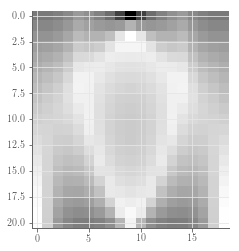

---- Curvature: 0.05 ----
Cylinder radius: 17.0
Road radius: 20.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 11.8393945931
Processing: pitch -- 34.0, yaw -- 180.0
Score: 12.8211959631
Processing: pitch -- 37.0, yaw -- 180.0
Score: 13.8069957638
Processing: pitch -- 40.0, yaw -- 180.0
Score: 14.8000871059
Processing: pitch -- 43.0, yaw -- 180.0
Score: 15.8043902972
Processing: pitch -- 46.0, yaw -- 180.0
Score: 16.8239989218
Processing: pitch -- 49.0, yaw -- 180.0
Score: 17.8624251139
Processing: pitch -- 52.0, yaw -- 180.0
Score: 18.9217824412
Processing: pitch -- 55.0, yaw -- 180.0
Score: 19.9998604421
Processing: pitch -- 58.0, yaw -- 180.0
Score: 20.9767907179
Processing: pitch -- 61.0, yaw -- 180.0
Score: 21.6579907584
Processing: pitch -- 64.0, yaw -- 180.0
Score: 22.1869626856
Processing: pitch -- 67.0, yaw -- 180.0
Score: 22.6637929352
Processing: pitch -- 70.0, yaw -- 180.0
Score: 23.1100435967
Processing: pitch -- 73.0, yaw -- 180.0
Score: 23.5252720385
Processing: pitch -

Score: 26.1338159681
Processing: pitch -- 55.0, yaw -- 240.0
Score: 25.2776910098
Processing: pitch -- 58.0, yaw -- 240.0
Score: 24.7969287843
Processing: pitch -- 61.0, yaw -- 240.0
Score: 24.4579135551
Processing: pitch -- 64.0, yaw -- 240.0
Score: 24.0402749201
Processing: pitch -- 67.0, yaw -- 240.0
Score: 23.4361043527
Processing: pitch -- 70.0, yaw -- 240.0
Score: 22.7051359909
Processing: pitch -- 73.0, yaw -- 240.0
Score: 21.8811113916
Processing: pitch -- 76.0, yaw -- 240.0
Score: 20.9475223838
Processing: pitch -- 79.0, yaw -- 240.0
Score: 19.8781788059
Processing: pitch -- 82.0, yaw -- 240.0
Score: 18.6426618065
Processing: pitch -- 85.0, yaw -- 240.0
Score: 17.2050421042
Processing: pitch -- 88.0, yaw -- 240.0
Score: 15.5218522844
Processing: pitch -- 91.0, yaw -- 240.0
Score: 13.5393576325
Processing: pitch -- 31.0, yaw -- 250.0
Score: 13.4592706463
Processing: pitch -- 34.0, yaw -- 250.0
Score: 16.871023068
Processing: pitch -- 37.0, yaw -- 250.0
Score: 20.8242301559
Proc

Score: 19.8781788059
Processing: pitch -- 82.0, yaw -- 300.0
Score: 18.6426618065
Processing: pitch -- 85.0, yaw -- 300.0
Score: 17.2050421042
Processing: pitch -- 88.0, yaw -- 300.0
Score: 15.5218522844
Processing: pitch -- 91.0, yaw -- 300.0
Score: 13.5393576325
Processing: pitch -- 31.0, yaw -- 310.0
Score: 15.4333589029
Processing: pitch -- 34.0, yaw -- 310.0
Score: 17.1580531175
Processing: pitch -- 37.0, yaw -- 310.0
Score: 19.0079366504
Processing: pitch -- 40.0, yaw -- 310.0
Score: 20.9964470859
Processing: pitch -- 43.0, yaw -- 310.0
Score: 23.1106064595
Processing: pitch -- 46.0, yaw -- 310.0
Score: 24.5752770759
Processing: pitch -- 49.0, yaw -- 310.0
Score: 24.899550007
Processing: pitch -- 52.0, yaw -- 310.0
Score: 24.425096168
Processing: pitch -- 55.0, yaw -- 310.0
Score: 23.84639384
Processing: pitch -- 58.0, yaw -- 310.0
Score: 23.2731105377
Processing: pitch -- 61.0, yaw -- 310.0
Score: 22.693002974
Processing: pitch -- 64.0, yaw -- 310.0
Score: 22.0906899722
Processi

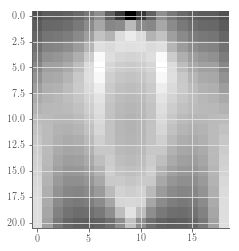

---- Curvature: 0.1 ----
Cylinder radius: 7.0
Road radius: 10.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 2.66840407398
Processing: pitch -- 34.0, yaw -- 180.0
Score: 4.1385898128
Processing: pitch -- 37.0, yaw -- 180.0
Score: 5.72529293601
Processing: pitch -- 40.0, yaw -- 180.0
Score: 7.30875286493
Processing: pitch -- 43.0, yaw -- 180.0
Score: 8.82018443736
Processing: pitch -- 46.0, yaw -- 180.0
Score: 10.2332042314
Processing: pitch -- 49.0, yaw -- 180.0
Score: 11.5465644166
Processing: pitch -- 52.0, yaw -- 180.0
Score: 12.7699086162
Processing: pitch -- 55.0, yaw -- 180.0
Score: 13.9151441461
Processing: pitch -- 58.0, yaw -- 180.0
Score: 14.9924686657
Processing: pitch -- 61.0, yaw -- 180.0
Score: 16.0088786166
Processing: pitch -- 64.0, yaw -- 180.0
Score: 16.9679626056
Processing: pitch -- 67.0, yaw -- 180.0
Score: 17.8701336809
Processing: pitch -- 70.0, yaw -- 180.0
Score: 18.7129638127
Processing: pitch -- 73.0, yaw -- 180.0
Score: 19.4915436623
Processing: pitch -- 7

Score: 24.4011214942
Processing: pitch -- 55.0, yaw -- 240.0
Score: 23.7456428853
Processing: pitch -- 58.0, yaw -- 240.0
Score: 23.1483870536
Processing: pitch -- 61.0, yaw -- 240.0
Score: 22.579545762
Processing: pitch -- 64.0, yaw -- 240.0
Score: 22.0158459524
Processing: pitch -- 67.0, yaw -- 240.0
Score: 21.4362762608
Processing: pitch -- 70.0, yaw -- 240.0
Score: 20.8201080099
Processing: pitch -- 73.0, yaw -- 240.0
Score: 20.1455060728
Processing: pitch -- 76.0, yaw -- 240.0
Score: 19.3882188674
Processing: pitch -- 79.0, yaw -- 240.0
Score: 18.5200635697
Processing: pitch -- 82.0, yaw -- 240.0
Score: 17.5069908219
Processing: pitch -- 85.0, yaw -- 240.0
Score: 16.3062599464
Processing: pitch -- 88.0, yaw -- 240.0
Score: 14.8623226479
Processing: pitch -- 91.0, yaw -- 240.0
Score: 13.100117619
Processing: pitch -- 31.0, yaw -- 250.0
Score: 16.7942475832
Processing: pitch -- 34.0, yaw -- 250.0
Score: 19.9398870277
Processing: pitch -- 37.0, yaw -- 250.0
Score: 24.386088798
Proces

Score: 18.5200635697
Processing: pitch -- 82.0, yaw -- 300.0
Score: 17.5069908219
Processing: pitch -- 85.0, yaw -- 300.0
Score: 16.3062599464
Processing: pitch -- 88.0, yaw -- 300.0
Score: 14.8623226479
Processing: pitch -- 91.0, yaw -- 300.0
Score: 13.100117619
Processing: pitch -- 31.0, yaw -- 310.0
Score: 13.6910298158
Processing: pitch -- 34.0, yaw -- 310.0
Score: 15.3320014047
Processing: pitch -- 37.0, yaw -- 310.0
Score: 17.1215068499
Processing: pitch -- 40.0, yaw -- 310.0
Score: 19.1089260189
Processing: pitch -- 43.0, yaw -- 310.0
Score: 21.2944318108
Processing: pitch -- 46.0, yaw -- 310.0
Score: 23.2152948763
Processing: pitch -- 49.0, yaw -- 310.0
Score: 23.749120228
Processing: pitch -- 52.0, yaw -- 310.0
Score: 23.0432019236
Processing: pitch -- 55.0, yaw -- 310.0
Score: 22.3880290119
Processing: pitch -- 58.0, yaw -- 310.0
Score: 21.7893955331
Processing: pitch -- 61.0, yaw -- 310.0
Score: 21.2165152925
Processing: pitch -- 64.0, yaw -- 310.0
Score: 20.6474325362
Proce

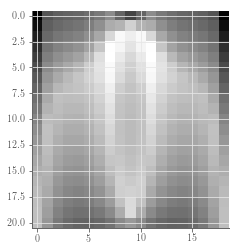

---- Curvature: 0.2 ----
Cylinder radius: 2.0
Road radius: 5.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 0.000707582944646
Processing: pitch -- 34.0, yaw -- 180.0
Score: 0.0108176884335
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.0763099964637
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.313491432583
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.878167804174
Processing: pitch -- 46.0, yaw -- 180.0
Score: 1.86837498628
Processing: pitch -- 49.0, yaw -- 180.0
Score: 3.25525360624
Processing: pitch -- 52.0, yaw -- 180.0
Score: 4.9021410574
Processing: pitch -- 55.0, yaw -- 180.0
Score: 6.63732030075
Processing: pitch -- 58.0, yaw -- 180.0
Score: 8.32146184363
Processing: pitch -- 61.0, yaw -- 180.0
Score: 9.87130450462
Processing: pitch -- 64.0, yaw -- 180.0
Score: 11.250779906
Processing: pitch -- 67.0, yaw -- 180.0
Score: 12.4507528047
Processing: pitch -- 70.0, yaw -- 180.0
Score: 13.4713140981
Processing: pitch -- 73.0, yaw -- 180.0
Score: 14.311893454
Processing: pit

Score: 22.7097505657
Processing: pitch -- 55.0, yaw -- 240.0
Score: 22.8125621064
Processing: pitch -- 58.0, yaw -- 240.0
Score: 22.018709296
Processing: pitch -- 61.0, yaw -- 240.0
Score: 20.9839179473
Processing: pitch -- 64.0, yaw -- 240.0
Score: 20.2418436973
Processing: pitch -- 67.0, yaw -- 240.0
Score: 19.5914134649
Processing: pitch -- 70.0, yaw -- 240.0
Score: 18.9715194232
Processing: pitch -- 73.0, yaw -- 240.0
Score: 18.3458297966
Processing: pitch -- 76.0, yaw -- 240.0
Score: 17.6842152877
Processing: pitch -- 79.0, yaw -- 240.0
Score: 16.9560458867
Processing: pitch -- 82.0, yaw -- 240.0
Score: 16.1257116702
Processing: pitch -- 85.0, yaw -- 240.0
Score: 15.1477171789
Processing: pitch -- 88.0, yaw -- 240.0
Score: 13.9591884202
Processing: pitch -- 91.0, yaw -- 240.0
Score: 12.4657066834
Processing: pitch -- 31.0, yaw -- 250.0
Score: 13.7117540752
Processing: pitch -- 34.0, yaw -- 250.0
Score: 16.7214164778
Processing: pitch -- 37.0, yaw -- 250.0
Score: 22.5585789821
Proc

Score: 16.9560458867
Processing: pitch -- 82.0, yaw -- 300.0
Score: 16.1257116702
Processing: pitch -- 85.0, yaw -- 300.0
Score: 15.1477171789
Processing: pitch -- 88.0, yaw -- 300.0
Score: 13.9591884202
Processing: pitch -- 91.0, yaw -- 300.0
Score: 12.4657066834
Processing: pitch -- 31.0, yaw -- 310.0
Score: 12.3534853748
Processing: pitch -- 34.0, yaw -- 310.0
Score: 13.8246869339
Processing: pitch -- 37.0, yaw -- 310.0
Score: 15.5085639184
Processing: pitch -- 40.0, yaw -- 310.0
Score: 17.4920648711
Processing: pitch -- 43.0, yaw -- 310.0
Score: 19.844047513
Processing: pitch -- 46.0, yaw -- 310.0
Score: 21.6919551156
Processing: pitch -- 49.0, yaw -- 310.0
Score: 22.0431744263
Processing: pitch -- 52.0, yaw -- 310.0
Score: 22.0417474546
Processing: pitch -- 55.0, yaw -- 310.0
Score: 22.1806077608
Processing: pitch -- 58.0, yaw -- 310.0
Score: 22.2886584244
Processing: pitch -- 61.0, yaw -- 310.0
Score: 20.439093797
Processing: pitch -- 64.0, yaw -- 310.0
Score: 19.5325623421
Proce

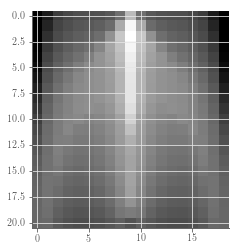

---- Curvature: 0.3 ----
Cylinder radius: 0.333333333333
Road radius: 3.33333333333
Processing: pitch -- 31.0, yaw -- 180.0
Score: 1.95701603409e-08
Processing: pitch -- 34.0, yaw -- 180.0
Score: 7.87372881664e-06
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.000552566319908
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.0110273262931
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.0900566022188
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.392759610913
Processing: pitch -- 49.0, yaw -- 180.0
Score: 1.10614187526
Processing: pitch -- 52.0, yaw -- 180.0
Score: 2.29731524937
Processing: pitch -- 55.0, yaw -- 180.0
Score: 3.8572454627
Processing: pitch -- 58.0, yaw -- 180.0
Score: 5.57960871404
Processing: pitch -- 61.0, yaw -- 180.0
Score: 7.2708804188
Processing: pitch -- 64.0, yaw -- 180.0
Score: 8.80349071139
Processing: pitch -- 67.0, yaw -- 180.0
Score: 10.1098376958
Processing: pitch -- 70.0, yaw -- 180.0
Score: 11.1569363238
Processing: pitch -- 73.0, yaw -- 180.0
Score: 

Score: 21.9301625964
Processing: pitch -- 55.0, yaw -- 240.0
Score: 21.8876035761
Processing: pitch -- 58.0, yaw -- 240.0
Score: 21.9960815656
Processing: pitch -- 61.0, yaw -- 240.0
Score: 22.2572579821
Processing: pitch -- 64.0, yaw -- 240.0
Score: 22.0292929765
Processing: pitch -- 67.0, yaw -- 240.0
Score: 19.2762683451
Processing: pitch -- 70.0, yaw -- 240.0
Score: 18.333370364
Processing: pitch -- 73.0, yaw -- 240.0
Score: 17.5701082985
Processing: pitch -- 76.0, yaw -- 240.0
Score: 16.8560888379
Processing: pitch -- 79.0, yaw -- 240.0
Score: 16.1311249461
Processing: pitch -- 82.0, yaw -- 240.0
Score: 15.3483324947
Processing: pitch -- 85.0, yaw -- 240.0
Score: 14.457501745
Processing: pitch -- 88.0, yaw -- 240.0
Score: 13.3927506452
Processing: pitch -- 91.0, yaw -- 240.0
Score: 12.0526251777
Processing: pitch -- 31.0, yaw -- 250.0
Score: 14.4962128884
Processing: pitch -- 34.0, yaw -- 250.0
Score: 18.049768632
Processing: pitch -- 37.0, yaw -- 250.0
Score: 24.9832711871
Proces

Score: 16.1311249461
Processing: pitch -- 82.0, yaw -- 300.0
Score: 15.3483324947
Processing: pitch -- 85.0, yaw -- 300.0
Score: 14.457501745
Processing: pitch -- 88.0, yaw -- 300.0
Score: 13.3927506452
Processing: pitch -- 91.0, yaw -- 300.0
Score: 12.0526251777
Processing: pitch -- 31.0, yaw -- 310.0
Score: 11.9824456874
Processing: pitch -- 34.0, yaw -- 310.0
Score: 13.3242277974
Processing: pitch -- 37.0, yaw -- 310.0
Score: 14.8985365863
Processing: pitch -- 40.0, yaw -- 310.0
Score: 16.8671467
Processing: pitch -- 43.0, yaw -- 310.0
Score: 19.3909422413
Processing: pitch -- 46.0, yaw -- 310.0
Score: 21.0262517779
Processing: pitch -- 49.0, yaw -- 310.0
Score: 21.0508519173
Processing: pitch -- 52.0, yaw -- 310.0
Score: 20.892618991
Processing: pitch -- 55.0, yaw -- 310.0
Score: 20.8564896169
Processing: pitch -- 58.0, yaw -- 310.0
Score: 20.9509710605
Processing: pitch -- 61.0, yaw -- 310.0
Score: 21.1808170758
Processing: pitch -- 64.0, yaw -- 310.0
Score: 21.5539710129
Processi

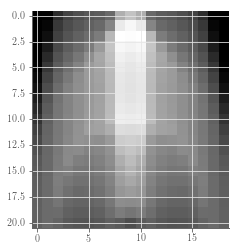

In [16]:
for curvature in curvatures:
    print("---- Curvature: {0} ----".format(curvature))
    camera_height = 6.0
#     resolution = (200, 200) # use same resolution for all
    fov_deg = (60.0, 60.0)
    yaw_range = 90 # degrees +- from center yaw position

    length = 2*np.pi/curvature # 1 full revolution

    path = Path()
    path.add_segment(curvature, length)
    road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

    # place camera halfway along road
    allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
    lhs_pos, lhs_direction = allowed_positions_orientations[0]
    rhs_pos, rhs_direction = allowed_positions_orientations[1]

    #TODO figure out which one is LHS versus RHS for positive curvature...
    # ====> the first element (lhs here) is OUT ie. away from center of curvature
    # ====> LHS is good for first tests of outside
    
    camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
    camera_pitches = np.arange(31.0, 92.0, 3)

    # convert lhs_direction into a yaw facing the road perpendicularly
    center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
    center_yaw_deg = np.rad2deg(center_yaw_rad) + 180 # TODO figure out automatically if the +180 is required
    camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)
    
    # cylinder charactistics
    road_pt = road.path.get_point_at(length/2.0)
    road_normal = road.path.get_normal_at(length/2.0)
    road_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0))
    cylinder_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0)) 
    cylinder_radius -= road.halfwidth 
    cylinder_radius -= road.side_offset
    cylinder_center = road_pt + road_normal * road_radius
    cylinder_direction = np.array([0.0, 0.0, 1.0])
    
    x_unit, y_unit = np.array([1.0,0,0]), np.array([0.0, 1.0, 0.0])
    
    path_points = []
    for d in np.arange(0, length, 0.5):
        path_points.append(road.path.get_point_at(d))
    path_points = np.array(path_points)
    
    
    print("Cylinder radius: {0}".format(cylinder_radius))
    print("Road radius: {0}".format(1/road.path.get_curvature_at(length/2.0)))

    scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
    for j, yaw in enumerate(camera_yaws):
        for i, pitch in enumerate(camera_pitches):
            print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
            name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
            camera = Camera(camera_position, pitch, yaw)
            camera.set_resolution(*resolution)
            camera.set_fov(*fov_deg)
            # set edge boundary for visual obstruction
            camera.attach_cylinder(cylinder_center, cylinder_direction, cylinder_radius)

            pixel_probabilities = camera.get_pixel_probabilities_for_road(road)

            # didn't want any pyplot stuff running
            # in case of leaking memory from open figures that I don't quite understand

#             plt.imshow(np.flip(pixel_probabilities, 0))
#             plt.gray()
#             plt.show()
            
#             fig = plt.figure()
#             ax = fig.add_subplot(111, projection='3d')
#             ax.view_init(elev=10., azim=0.0)
#             plot_vector(ax, camera.position, camera.position+camera.orientation_vector)
#             corners = camera.get_corners()
#             corners = np.array([x for x in corners if x is not None])
#             plot_points(ax, corners)
#             plot_points(ax, path_points)
#             plot_vector(ax, cylinder_center, cylinder_center + cylinder_direction)
#             plot_vector(ax, cylinder_center, cylinder_center+x_unit*cylinder_radius)
#             plot_vector(ax, cylinder_center, cylinder_center+y_unit*cylinder_radius)
#             plt.show()
            



            # calculate error radius at each pixel
            error_bounds = error_radius_across_pixels(camera)
    #         plt.imshow(error_bounds)
    #         plt.gray()
    #         plt.imsave(save_dir + name + "_error_bounds.png")

            target = (1.0/(1+error_bounds)) * pixel_probabilities
    #         plt.imshow(product)
    #         plt.gray()
    #         plt.imsave(save_dir + name + "_product.png")
            # take the sum => now have an expected value!

            score = np.sum(target)
            print("Score: {0}".format(score))
            scores[i, j] = score
    plt.imshow(scores)
    plt.gray()
    plt.show()
    curvature_score_maps.append(scores)

In [20]:
curvature_score_maps = np.array(curvature_score_maps)
np.save("curved_roads_{0}x{1}_6m-4_two_stddev.npy".format(*resolution), curvature_score_maps)


In [15]:
n_pitch = 21
n_yaw = 19
# if lost expensive computation again... can use printed strings to recover data
def string_to_scores(raw_str, n_pitch, n_yaw, pitch_axis_first=True):
    data = raw_str.split('\n')
    recovered = []
    for x in data:
        if 'Score' in x:
            recovered.append(float(x.split(':')[1].strip()))
    
    scores = np.array(recovered)
    if pitch_axis_first:
        # ie. the first axis printed was pitch
        scores = scores.reshape(n_pitch, n_yaw).T
    else:
        scores = scores.reshape(n_pitch, n_yaw)
    return scores

In [31]:
# --- resoume from saved maps ---
curvature_score_maps = np.load("curved_roads_{0}x{1}_6m-4_two_stddev.npy".format(*(300,300)))


Curvature: 0.001, Radius: 1000.0, Circumference: 6283.18530718


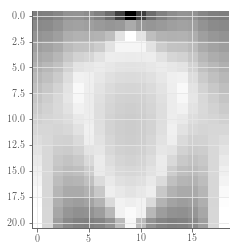

Curvature: 0.005, Radius: 200.0, Circumference: 1256.63706144


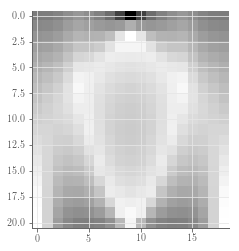

Curvature: 0.01, Radius: 100.0, Circumference: 628.318530718


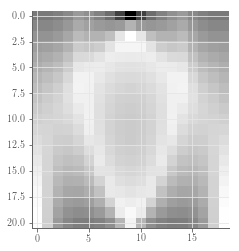

Curvature: 0.05, Radius: 20.0, Circumference: 125.663706144


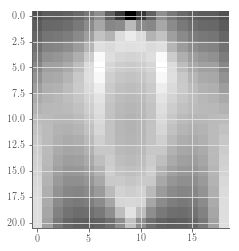

Curvature: 0.1, Radius: 10.0, Circumference: 62.8318530718


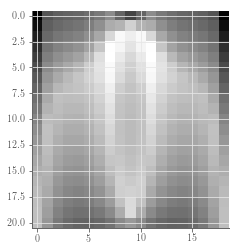

Curvature: 0.2, Radius: 5.0, Circumference: 31.4159265359


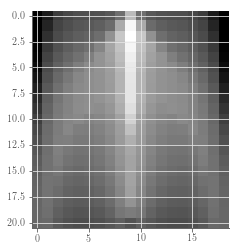

Curvature: 0.3, Radius: 3.33333333333, Circumference: 20.9439510239


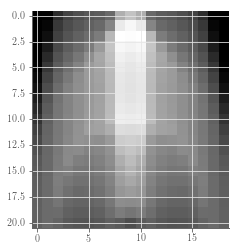

In [34]:
for i, score_map in enumerate(curvature_score_maps):
    print("Curvature: {0}, Radius: {1}, Circumference: {2}".format(curvatures[i], 1.0/curvatures[i], 2*np.pi/curvatures[i]))
    plt.imshow(score_map)
    plt.gray()
    plt.show()

In [19]:
# get sorted indices
sorted_indices = np.array(np.unravel_index(np.argsort(scores, axis=None), scores.shape)).T
print(sorted_indices)

[[ 0  0]
 [ 0 18]
 [ 1  0]
 [ 1 18]
 [ 2  0]
 [ 2 18]
 [ 3  0]
 [ 3 18]
 [ 4  0]
 [ 4 18]
 [ 0  1]
 [ 0 17]
 [ 5  0]
 [ 5 18]
 [ 1  1]
 [ 1 17]
 [ 6  0]
 [ 6 18]
 [ 2  1]
 [ 2 17]
 [ 7  0]
 [ 7 18]
 [ 8  0]
 [ 8 18]
 [ 3  1]
 [ 3 17]
 [ 9  0]
 [ 9 18]
 [ 4  1]
 [ 4 17]
 [ 0  2]
 [ 0 16]
 [10  0]
 [10 18]
 [ 5  1]
 [ 5 17]
 [ 1  2]
 [ 1 16]
 [11  0]
 [11 18]
 [ 2  2]
 [ 2 16]
 [ 6  1]
 [ 6 17]
 [ 0  3]
 [ 0 15]
 [12  0]
 [12 18]
 [ 3  2]
 [ 3 16]
 [ 1  3]
 [ 1 15]
 [ 7  1]
 [ 7 17]
 [20  9]
 [ 0  4]
 [ 0 14]
 [13  0]
 [13 18]
 [ 4  2]
 [ 4 16]
 [ 2  3]
 [ 2 15]
 [20 13]
 [20  5]
 [20 14]
 [20  4]
 [ 8  1]
 [ 8 17]
 [ 1  4]
 [ 1 14]
 [14  0]
 [14 18]
 [ 0  5]
 [ 0 13]
 [20  6]
 [20 12]
 [20  3]
 [20 15]
 [20 10]
 [20  8]
 [15  0]
 [15 18]
 [ 0  6]
 [ 0 12]
 [ 9  1]
 [ 9 17]
 [ 5  2]
 [ 5 16]
 [19 14]
 [19  4]
 [ 3  3]
 [ 3 15]
 [19 13]
 [19  5]
 [16  0]
 [16 18]
 [17  0]
 [17 18]
 [18  0]
 [18 18]
 [ 2  4]
 [ 2 14]
 [19  0]
 [19 18]
 [20  0]
 [20 18]
 [19 15]
 [19  3]
 [10  1]
 [10 17]
 